<a href="https://colab.research.google.com/github/Abhiraj36/Compression01/blob/main/CNN_compression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchvision.utils import save_image
import os
!pip install scikit-image wandb

from skimage.metrics import structural_similarity as ssim
import numpy as np
import time


import wandb
wandb.init(
    project="skip-autoencoder-compression",
    config={
        "epochs_ae": 5,
        "epochs_comp": 10,
        "batch_size": 128,
        "lr": 0.001,
        "dataset": "CIFAR10"
    }
)
config = wandb.config


# Ensure output directory exists
os.makedirs("output_images", exist_ok=True)

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Skip-Connected Autoencoder

class SkipAutoencoder(nn.Module):
    def __init__(self):
        super(SkipAutoencoder, self).__init__()
        # Encoder
        self.enc1 = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1), nn.ReLU(inplace=True))
        self.enc2 = nn.Sequential(
            nn.Conv2d(64, 128, 3, stride=2, padding=1), nn.ReLU(inplace=True))  # 16x16
        self.enc3 = nn.Sequential(
            nn.Conv2d(128, 256, 3, stride=2, padding=1), nn.ReLU(inplace=True))  # 8x8

        # Decoder
        self.dec1 = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1), nn.ReLU(inplace=True))  # 16x16
        self.dec2 = nn.Sequential(
            nn.ConvTranspose2d(256, 64, 4, stride=2, padding=1), nn.ReLU(inplace=True))  # 32x32
        self.dec3 = nn.Sequential(
            nn.Conv2d(128, 3, 3, padding=1), nn.Tanh())

    def forward(self, x):
        e1 = self.enc1(x)  # [B, 64, 32, 32]
        e2 = self.enc2(e1) # [B, 128, 16, 16]
        e3 = self.enc3(e2) # [B, 256, 8, 8]

        d1 = self.dec1(e3)                # [B, 128, 16, 16]
        d1_cat = torch.cat([d1, e2], 1)   # [B, 256, 16, 16]

        d2 = self.dec2(d1_cat)           # [B, 64, 32, 32]
        d2_cat = torch.cat([d2, e1], 1)  # [B, 128, 32, 32]

        out = self.dec3(d2_cat)          # [B, 3, 32, 32]

        return out, e3  # output and latent



# Latent Compressor

class LatentCompressor(nn.Module):
    def __init__(self, input_channels=256):
        super(LatentCompressor, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(input_channels, 128, kernel_size=3, stride=2, padding=1),  # 8x8 → 4x4
            nn.ReLU(),
            nn.Conv2d(128, 64, kernel_size=3, stride=2, padding=1),              # 4x4 → 2x2
            nn.ReLU(),
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 128, kernel_size=4, stride=2, padding=1),     # 2x2 → 4x4
            nn.ReLU(),
            nn.ConvTranspose2d(128, 256, kernel_size=4, stride=2, padding=1),    # 4x4 → 8x8
            nn.ReLU(),
        )

        # Final projection to match the latent shape exactly (in case of residual mismatch)
        self.project = nn.Conv2d(256, input_channels, kernel_size=1)

    def forward(self, x):
        z = self.encoder(x)
        out = self.decoder(z)
        projected = self.project(out)
        return projected


# Data Preparation

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # normalize to [-1,1]
])

trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

trainloader = DataLoader(trainset, batch_size=128, shuffle=True)
testloader = DataLoader(testset, batch_size=16, shuffle=False)


# Initialize Models

autoencoder = SkipAutoencoder().to(device)
latent_compressor = LatentCompressor().to(device)


# Train Autoencoder First (optional: or load pretrained)

ae_optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)
ae_criterion = nn.MSELoss()

print("\nTraining Autoencoder...")
autoencoder.train()
for epoch in range(config.epochs_ae):
    total_loss = 0.0
    for imgs, _ in trainloader:
        imgs = imgs.to(device)
        ae_optimizer.zero_grad()
        recon, _ = autoencoder(imgs)
        loss = ae_criterion(recon, imgs)
        loss.backward()
        ae_optimizer.step()
        total_loss += loss.item() * imgs.size(0)

    avg_loss = total_loss / len(trainloader.dataset)
    print(f"Autoencoder Epoch [{epoch+1}/{config.epochs_ae}], Loss: {avg_loss:.6f}")

    #  Log to wandb
    wandb.log({
        "train/ae_loss": avg_loss,
        "epoch": epoch + 1,
        "train/recon_sample": [wandb.Image(recon[0].cpu(), caption="Reconstructed"),
                               wandb.Image(imgs[0].cpu(), caption="Original")]
    })



epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
eval/bpp,▁
eval/compressed_latent_size_kb,▁
eval/compression_ratio,▁
eval/compression_time_ms,▁
eval/decompression_time_ms,▁
eval/original_latent_size_kb,▁
eval/psnr_compressed,▁
eval/psnr_reconstruction,▁
eval/ssim,▁
train/ae_loss,█▂▁▁▁



Training Autoencoder...
Autoencoder Epoch [1/5], Loss: 0.004992
Autoencoder Epoch [2/5], Loss: 0.000558
Autoencoder Epoch [3/5], Loss: 0.000348
Autoencoder Epoch [4/5], Loss: 0.000262
Autoencoder Epoch [5/5], Loss: 0.000209


In [20]:

# Train Latent Compressor

latent_compressor.train()
comp_optimizer = optim.Adam(latent_compressor.parameters(), lr=0.001)
comp_criterion = nn.MSELoss()

print("\nTraining Latent Compressor...")
latent_compressor.train()
for epoch in range(config.epochs_comp):
    total_loss = 0.0
    for imgs, _ in trainloader:
        imgs = imgs.to(device)
        with torch.no_grad():
            _, e3 = autoencoder(imgs)
        comp_optimizer.zero_grad()
        recon_e3 = latent_compressor(e3)
        loss = comp_criterion(recon_e3, e3)
        loss.backward()
        comp_optimizer.step()
        total_loss += loss.item() * imgs.size(0)

    avg_loss = total_loss / len(trainloader.dataset)
    print(f"Compressor Epoch [{epoch+1}/{config.epochs_comp}], Loss: {avg_loss:.6f}")

    #  Log to wandb
    wandb.log({
        "train/compressor_loss": avg_loss,
        "epoch": config.epochs_ae + epoch + 1
    })




Training Latent Compressor...
Compressor Epoch [1/10], Loss: 0.008070
Compressor Epoch [2/10], Loss: 0.003024
Compressor Epoch [3/10], Loss: 0.002189
Compressor Epoch [4/10], Loss: 0.001816
Compressor Epoch [5/10], Loss: 0.001625
Compressor Epoch [6/10], Loss: 0.001457
Compressor Epoch [7/10], Loss: 0.001343
Compressor Epoch [8/10], Loss: 0.001253
Compressor Epoch [9/10], Loss: 0.001182
Compressor Epoch [10/10], Loss: 0.001131


In [19]:
wandb.watch(autoencoder, log="all", log_freq=100)
wandb.watch(latent_compressor, log="all", log_freq=100)


In [21]:

import time
from torchvision.utils import save_image

# Evaluation & Saving Images
autoencoder.eval()
latent_compressor.eval()

with torch.no_grad():
    imgs, _ = next(iter(testloader))
    imgs = imgs.to(device)

    # Original latent
    e1 = autoencoder.enc1(imgs)
    e2 = autoencoder.enc2(e1)
    e3 = autoencoder.enc3(e2)

    # --- Compression Time ---
    start = time.time()
    z = latent_compressor.encoder(e3)
    comp_time = time.time() - start

    # --- Decompression Time ---
    start = time.time()
    decoded_e3 = latent_compressor.decoder(z)
    decomp_time = time.time() - start

    print(f"Compression time: {comp_time * 1000:.2f} ms")
    print(f"Decompression time: {decomp_time * 1000:.2f} ms")

    # Decode full image using decoded_e3, e2, e1
    d1 = autoencoder.dec1(decoded_e3)
    d1_cat = torch.cat([d1, e2], 1)
    d2 = autoencoder.dec2(d1_cat)
    d2_cat = torch.cat([d2, e1], 1)
    recon_from_compressed = autoencoder.dec3(d2_cat)

    # Save all images
    save_image(imgs * 0.5 + 0.5, "output_images/original.png")
    recon_img, _ = autoencoder(imgs)
    save_image(recon_img * 0.5 + 0.5, "output_images/reconstructed.png")
    save_image(recon_from_compressed * 0.5 + 0.5, "output_images/recon_from_compressed.png")

    # Size info
    original_size = e3.nelement() * 4  # bytes
    compressed_size = z.nelement() * 4  # bytes
    print(f"Original e3 size: {original_size / 1024:.2f} KB")
    print(f"Compressed z size: {compressed_size / 1024:.2f} KB")

    print("Saved original, reconstructed, and compressed recon images.")


Compression time: 0.17 ms
Decompression time: 0.21 ms
Original e3 size: 1024.00 KB
Compressed z size: 16.00 KB
Saved original, reconstructed, and compressed recon images.


In [22]:
import torch.nn.functional as F
import wandb
import numpy as np
from torchvision.utils import make_grid, save_image
from skimage.metrics import structural_similarity as ssim
import time

# PSNR helper
def psnr(img1, img2):
    mse = F.mse_loss(img1, img2)
    if mse == 0:
        return float('inf')
    return 20 * torch.log10(2.0 / torch.sqrt(mse))  # inputs normalized to [-1, 1]

# Evaluation
autoencoder.eval()
latent_compressor.eval()

with torch.no_grad():
    imgs, _ = next(iter(testloader))
    imgs = imgs.to(device)

    # Encode original image
    e1 = autoencoder.enc1(imgs)
    e2 = autoencoder.enc2(e1)
    e3 = autoencoder.enc3(e2)

    #  Compression Time
    start = time.time()
    z = latent_compressor.encoder(e3)
    comp_time = time.time() - start

    #  Decompression Time
    start = time.time()
    decoded_e3 = latent_compressor.decoder(z)
    decomp_time = time.time() - start

    # Decode image from compressed latent
    d1 = autoencoder.dec1(decoded_e3)
    d1_cat = torch.cat([d1, e2], 1)
    d2 = autoencoder.dec2(d1_cat)
    d2_cat = torch.cat([d2, e1], 1)
    recon_from_compressed = autoencoder.dec3(d2_cat)

    # AE reconstruction (not compressed)
    recon_img, _ = autoencoder(imgs)

    # SSIM Calculation
    original_np = imgs[0].permute(1, 2, 0).cpu().numpy()
    recon_np = recon_from_compressed[0].permute(1, 2, 0).cpu().numpy()
    original_np = (original_np + 1) / 2
    recon_np = (recon_np + 1) / 2
    ssim_val = np.mean([
        ssim(original_np[:, :, c], recon_np[:, :, c], data_range=1.0)
        for c in range(3)
    ])

    # Save reconstructions
    save_image(imgs * 0.5 + 0.5, "output_images/original.png")
    save_image(recon_img * 0.5 + 0.5, "output_images/reconstructed.png")
    save_image(recon_from_compressed * 0.5 + 0.5, "output_images/recon_from_compressed.png")

    # PSNRs
    psnr_recon = psnr(recon_img, imgs)
    psnr_compressed = psnr(recon_from_compressed, imgs)

    # Size info
    original_size_kb = e3.nelement() * 4 / 1024
    compressed_size_kb = z.nelement() * 4 / 1024
    total_pixels = imgs.shape[2] * imgs.shape[3] * imgs.shape[1]
    bpp = (z.nelement() * 32) / total_pixels  # float32 is 32 bits

    # Error map
    error_map = torch.abs(imgs - recon_from_compressed)
    grid = make_grid(error_map * 5.0, nrow=4, normalize=True)

    # wandb logging
    wandb.log({
        "eval/ssim": ssim_val,
        "eval/bpp": bpp,
        "eval/compression_time_ms": comp_time * 1000,
        "eval/decompression_time_ms": decomp_time * 1000,
        "eval/psnr_reconstruction": psnr_recon,
        "eval/psnr_compressed": psnr_compressed,
        "eval/compression_ratio": original_size_kb / compressed_size_kb,
        "eval/original_vs_recon": [
            wandb.Image(imgs[0] * 0.5 + 0.5, caption="Original"),
            wandb.Image(recon_img[0] * 0.5 + 0.5, caption="Recon (AE)"),
            wandb.Image(recon_from_compressed[0] * 0.5 + 0.5, caption="Recon (Compressed)")
        ],
        "eval/error_map": wandb.Image(grid, caption="|Original - CompressedRecon| x5"),
        "eval/original_latent_size_kb": original_size_kb,
        "eval/compressed_latent_size_kb": compressed_size_kb,
      "eval/rate_distortion_point": wandb.plot.scatter(
    wandb.Table(data=[[compressed_size_kb, psnr_compressed]], columns=["Compressed Size (KB)", "PSNR"]),
    "Compressed Size (KB)",
    "PSNR",
    title="Rate-Distortion"
)

    })

    print(f"SSIM: {ssim_val:.4f}")
    print(f"PSNR (reconstructed): {psnr_recon:.2f}")
    print(f"PSNR (compressed recon): {psnr_compressed:.2f}")
    print(f"BPP: {bpp:.4f}")
    print(f"Original latent size: {original_size_kb:.2f} KB")
    print(f"Compressed latent size: {compressed_size_kb:.2f} KB")
    print(f"Compression time: {comp_time * 1000:.2f} ms")
    print(f"Decompression time: {decomp_time * 1000:.2f} ms")



SSIM: 0.9896
PSNR (reconstructed): 43.42
PSNR (compressed recon): 32.85
BPP: 42.6667
Original latent size: 1024.00 KB
Compressed latent size: 16.00 KB
Compression time: 0.16 ms
Decompression time: 0.16 ms


In [23]:
import numpy as np

# Quantization Function
class QuantizeSTE(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input):
        return torch.round(input)

    @staticmethod
    def backward(ctx, grad_output):
        return grad_output

def quantize(input):
    return QuantizeSTE.apply(input)

# Evaluation & Compression Pipeline

autoencoder.eval()
latent_compressor.eval()

with torch.no_grad():
    imgs, _ = next(iter(testloader))
    imgs = imgs.to(device)

    # Get latent representations
    e1 = autoencoder.enc1(imgs)
    e2 = autoencoder.enc2(e1)
    e3 = autoencoder.enc3(e2)

    # Compress e3 to z
    z = latent_compressor.encoder(e3)
    print(f"Compressed shape (before quantization): {z.shape}")

    # Apply quantization
    z_quant = quantize(z)

    # Save to binary
    z_quant_int = torch.clamp(torch.round(z_quant * 127), -128, 127).to(torch.int8)
    z_np = z_quant_int.cpu().numpy()
    os.makedirs("output_images", exist_ok=True)
    z_np.tofile("output_images/compressed_latent.bin")

    quantized_size = os.path.getsize("output_images/compressed_latent.bin") / 1024
    print(f"Quantized latent saved as binary file (Size: {quantized_size:.2f} KB)")


import zlib

# Zlib Entropy Coding
z_bytes = z_np.tobytes()
zlib_compressed = zlib.compress(z_bytes, level=9)

# Save to file
with open("output_images/compressed_latent_zlib.bin", "wb") as f:
    f.write(zlib_compressed)

# Report size
zlib_size_kb = len(zlib_compressed) / 1024
print(f"Zlib-compressed latent size: {zlib_size_kb:.2f} KB")

# Optional: Decode from Zlib for verification
with open("output_images/compressed_latent_zlib.bin", "rb") as f:
    zlib_loaded = f.read()

decompressed_bytes = zlib.decompress(zlib_loaded)
decompressed_np = np.frombuffer(decompressed_bytes, dtype=np.int8)
decompressed_tensor = torch.from_numpy(decompressed_np).float() / 127
decompressed_tensor = decompressed_tensor.view_as(z).to(device)

recon_ae, _ = autoencoder(imgs)

# Decode and save image from zlib-compressed
decoded_e3_zlib = latent_compressor.decoder(decompressed_tensor)
d1_zlib = autoencoder.dec1(decoded_e3_zlib)
d1_cat_zlib = torch.cat([d1_zlib, e2], 1)
d2_zlib = autoencoder.dec2(d1_cat_zlib)
d2_cat_zlib = torch.cat([d2_zlib, e1], 1)
recon_zlib = autoencoder.dec3(d2_cat_zlib)
save_image(recon_zlib * 0.5 + 0.5, "output_images/recon_from_zlib.png")
# Zlib Part ends here
print("Saved reconstruction from zlib-compressed latent.")

# Load from binary and decompress
loaded_np = np.fromfile("output_images/compressed_latent.bin", dtype=np.int8)
loaded_tensor = torch.from_numpy(loaded_np).float() / 127  # Rescale to [-1, 1]
loaded_tensor = loaded_tensor.view_as(z).to(device)

decoded_e3 = latent_compressor.decoder(loaded_tensor)

# Final decoding pipeline
d1 = autoencoder.dec1(decoded_e3)
d1_cat = torch.cat([d1, e2], 1)
d2 = autoencoder.dec2(d1_cat)
d2_cat = torch.cat([d2, e1], 1)
recon_from_bin = autoencoder.dec3(d2_cat)

# Save all images
save_image(imgs * 0.5 + 0.5, "output_images/original.png")
recon_img, _ = autoencoder(imgs)
save_image(recon_img * 0.5 + 0.5, "output_images/reconstructed.png")
save_image(recon_from_bin * 0.5 + 0.5, "output_images/recon_from_loaded_compressed.png")

# Size info
original_size = e3.nelement() * 4  # float32
compressed_size = z.nelement() * 4
print(f"Original e3 size: {original_size / 1024:.2f} KB")
print(f"Compressed z (float32) size: {compressed_size / 1024:.2f} KB")



Compressed shape (before quantization): torch.Size([16, 64, 2, 2])
Quantized latent saved as binary file (Size: 4.00 KB)
Zlib-compressed latent size: 0.36 KB
Saved reconstruction from zlib-compressed latent.
Original e3 size: 1024.00 KB
Compressed z (float32) size: 16.00 KB


In [24]:
# Simple quantization by scaling and rounding
z_quantized = torch.round(z * 127)  # Scale latent values roughly to int8 range [-127, 127]
z_quantized = z_quantized.to(torch.int8)  # Convert tensor to int8 type for smaller size


In [25]:
# Convert to NumPy array on CPU and save as raw binary file
z_np = z_quantized.cpu().numpy()
os.makedirs("output_images", exist_ok=True)  # Make sure output folder exists
z_np.tofile("output_images/compressed_latent.bin")

print("Quantized latent saved as binary file: output_images/compressed_latent.bin")


Quantized latent saved as binary file: output_images/compressed_latent.bin


In [26]:
# Calculate and print size of quantized latent in KB
quantized_size = os.path.getsize("output_images/compressed_latent.bin") / 1024
print(f"Quantized latent binary size: {quantized_size:.2f} KB")


Quantized latent binary size: 4.00 KB


In [27]:
# Load quantized latent from binary file
loaded_np = np.fromfile("output_images/compressed_latent.bin", dtype=np.int8)
loaded_tensor = torch.from_numpy(loaded_np).float() / 127  # Scale back to approx original range

# Reshape to latent tensor shape (same as z)
loaded_tensor = loaded_tensor.view_as(z).to(device)

# Decode latent as usual
with torch.no_grad():
    decoded_e3_loaded = latent_compressor.decoder(loaded_tensor)

    d1_loaded = autoencoder.dec1(decoded_e3_loaded)
    d1_cat_loaded = torch.cat([d1_loaded, e2], 1)
    d2_loaded = autoencoder.dec2(d1_cat_loaded)
    d2_cat_loaded = torch.cat([d2_loaded, e1], 1)
    recon_loaded = autoencoder.dec3(d2_cat_loaded)

    save_image(recon_loaded * 0.5 + 0.5, "output_images/recon_from_loaded_compressed.png")
    print("Saved reconstructed image from loaded compressed latent.")


Saved reconstructed image from loaded compressed latent.


In [28]:
import torch.nn.functional as F
import math

def calculate_psnr(img1, img2):
    mse = F.mse_loss(img1, img2)
    if mse == 0:
        return float('inf')
    psnr = 20 * math.log10(1.0) - 10 * math.log10(mse.item())
    return psnr

# === Evaluation with Metrics ===
autoencoder.eval()
latent_compressor.eval()

with torch.no_grad():
    imgs, _ = next(iter(testloader))
    imgs = imgs.to(device)

    # Original encoding
    e1 = autoencoder.enc1(imgs)
    e2 = autoencoder.enc2(e1)
    e3 = autoencoder.enc3(e2)

    # Latent compression
    z = latent_compressor.encoder(e3)
    z_quant = quantize(z)
    z_int8 = torch.clamp(torch.round(z_quant * 127), -128, 127).to(torch.int8)
    z_np = z_int8.cpu().numpy()

    # Save zlib compressed version
    import zlib
    z_bytes = z_np.tobytes()
    zlib_compressed = zlib.compress(z_bytes, level=9)

    # Decompress for reconstruction
    decompressed_bytes = zlib.decompress(zlib_compressed)
    decompressed_np = np.frombuffer(decompressed_bytes, dtype=np.int8)
    decompressed_tensor = torch.from_numpy(decompressed_np.copy()).float() / 127
    decompressed_tensor = decompressed_tensor.view_as(z).to(device)

    # Decode
    decoded_e3 = latent_compressor.decoder(decompressed_tensor)
    d1 = autoencoder.dec1(decoded_e3)
    d1_cat = torch.cat([d1, e2], 1)
    d2 = autoencoder.dec2(d1_cat)
    d2_cat = torch.cat([d2, e1], 1)
    recon_zlib = autoencoder.dec3(d2_cat)

    # PSNR
    psnr_recon = calculate_psnr(imgs, recon_zlib)
    print(f"PSNR (reconstruction from zlib compressed latent): {psnr_recon:.2f} dB")

    # Sizes
    original_e3_size_kb = e3.nelement() * 4 / 1024  # float32
    compressed_z_kb = z.nelement() * 4 / 1024       # float32
    quantized_z_kb = z_int8.nelement() / 1024       # int8
    zlib_kb = len(zlib_compressed) / 1024

    # Compression ratio
    ratio = original_e3_size_kb / zlib_kb

    print(f"Original latent size: {original_e3_size_kb:.2f} KB")
    print(f"Compressed (z float32): {compressed_z_kb:.2f} KB")
    print(f"Quantized (int8): {quantized_z_kb:.2f} KB")
    print(f"Zlib compressed size: {zlib_kb:.2f} KB")
    print(f"Effective compression ratio: {ratio:.2f}x")


PSNR (reconstruction from zlib compressed latent): 27.97 dB
Original latent size: 1024.00 KB
Compressed (z float32): 16.00 KB
Quantized (int8): 4.00 KB
Zlib compressed size: 0.36 KB
Effective compression ratio: 2811.20x


In [36]:
from torchvision.utils import make_grid, save_image

with torch.no_grad():
    recon_ae, _ = autoencoder(imgs)  # recon_ae shape: [16, 3, 32, 32]
    recon_ae = recon_ae * 0.5 + 0.5
    recon_zlib = recon_zlib * 0.5 + 0.5
    imgs_vis = imgs * 0.5 + 0.5

image_grid = make_grid(
    torch.cat([imgs_vis, recon_ae, recon_zlib], dim=0),
    nrow=imgs.size(0),
    padding=2
)
save_image(image_grid, "output_images/comparison_grid.png")



In [37]:
import matplotlib.pyplot as plt
import numpy as np

error_map = torch.abs(imgs_vis - recon_zlib).mean(dim=1, keepdim=True)
save_image(error_map, "output_images/error_map.png")


Saved error map image.


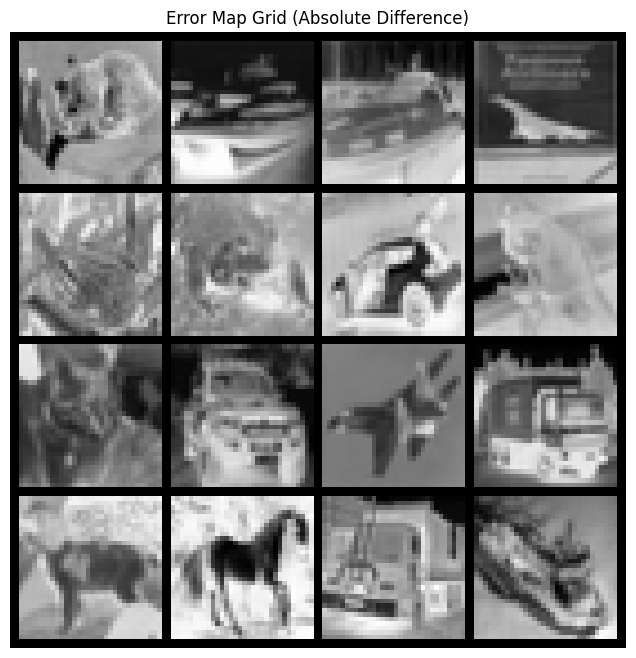

In [38]:
import torch
from torchvision.utils import save_image, make_grid
import matplotlib.pyplot as plt

# Calculate absolute error map (grayscale)
error_map = torch.abs(imgs_vis - recon_zlib).mean(dim=1, keepdim=True)  # [B,1,H,W]

# Save error map images grid
save_image(error_map, "output_images/error_map.png")
print("Saved error map image.")

# Display error map grid using matplotlib
grid_img = make_grid(error_map, nrow=4, normalize=True)  # Normalize for better visibility

plt.figure(figsize=(8, 8))
plt.imshow(grid_img.permute(1, 2, 0).cpu(), cmap='gray')
plt.axis('off')
plt.title("Error Map Grid (Absolute Difference)")
plt.show()


In [45]:
wandb.log({
    "eval/rate_distortion_point": wandb.plot.scatter(
        wandb.Table(data=[[compressed_size_kb, -psnr_compressed]], columns=["Compressed Size (KB)", "-PSNR"]),
        "Compressed Size (KB)",
        "-PSNR",
        title="Rate-Distortion Curve (Negative PSNR)"
    )
})



In [42]:
wandb.log({
    "compression/psnr": psnr_compressed.item(),
    "compression/size_kb": compressed_size_kb,
    "compression/error_map": wandb.Image(grid, caption="|Original - CompressedRecon| x5")
})


In [43]:
import shutil
from google.colab import files

# Zip the folder
shutil.make_archive("output_images", 'zip', "output_images")

# Download the zip file
files.download("output_images.zip")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>